In [7]:
%matplotlib inline

import numpy as np
import sys
import math
import os
import time
import matplotlib.pyplot as plt
import seaborn

In [57]:

"""
Generate publication figures.

* Water presence/absence
* Fig 3B: Unnormalized autocorrelation functions for WT +/- Tpx2
* Fig 3C: Slow component of autocorrelation times and populations for mutants
* alphaC helix RMSD

"""

#hbond_basepath = '/cbio/jclab/projects/behrj/AURKA_UMN/'
hbond_basepath = 'data' # location of extracted trajectory features
output_basepath = 'figures'

if not os.path.exists(output_basepath):
    os.makedirs(output_basepath)

# Parameters
nclones = 50 # number of CLONEs per RUN
projects = ['11414', '11419', '11418', '11423']
nruns = 7 # number of runs per project
resid = 185 # residue number used in constructing paths

# location of simulation data for each mutant
simulations = {
    '+Tpx2 WT' : [('11414', 'RUN0'), ('11419', 'RUN0'), ('11419', 'RUN1'), ('11419', 'RUN2'), ('11419', 'RUN3')],
    '+Tpx2 Q185C' : [('11414', 'RUN1')],
    '+Tpx2 Q185L' : [('11419', 'RUN2')],
    '-Tpx2 WT' : [('11418', 'RUN0'), ('11418', 'RUN1'), ('11418', 'RUN2'), ('11418', 'RUN3'), ('11418', 'RUN4')],
    '-Tpx2 Q185C' : [('11423', 'RUN0')],
    '-Tpx2 Q185L' : [('11423', 'RUN1')],
}

def squeeze_empty_trajectories(W):
    """
    Squeeze out empty trajectories that are just [None, ..., None]

    Parameters
    ----------
    W : np.array of dimension (ntraj, nframes)
        The trajectory to squeeze.

    Returns
    -------
    Wsqueezed : np.array of dimension (ntraj_squeezed, nframes)
        Squeezed version of W
    """
    non_empty_trajectories = list()
    for traj in range(W.shape[0]):
        if not np.all(np.equal(W[traj,:],  None)):
            non_empty_trajectories.append(traj)
    Wsqueezed = W[non_empty_trajectories,:]
    print('Squeezed out %d empty trajectories' % (W.shape[0] - Wsqueezed.shape[0]))
    return Wsqueezed

def retrieve_data(key):
    """
    Compile all available data for the specified simulation.

    Parameters
    ----------
    key : str
        The key into 'simulations' to identify projects and RUNs associated with the simulation data.

    Returns
    -------
    W1 : np.array shape (nsim, nsamples)
        Water 1 sets
    W2 : np.array shape (nsim, nsamples)
        Water 2 sets
    """
    print("Retrieving data for '%s'..." % key)
    [W1, W2] = [list(), list()]
    for (project,run) in simulations[key]:
        W1.append( np.load(os.path.join(hbond_basepath, 'output-%(project)s/data/%(run)s-274N-oxygen-indices.npy' % vars())) )
        W2.append( np.load(os.path.join(hbond_basepath, 'output-%(project)s/data/%(run)s-W2-181185-or275-oxygen-indices.npy' % vars())) )
    [W1, W2] = [np.vstack(W1), np.vstack(W2)]
    # Squeeze out rows that are just None
    [W1, W2] = [squeeze_empty_trajectories(W1), squeeze_empty_trajectories(W2)]
    return [W1, W2]

In [58]:
# Constuct binary arrays
def water_occupation_array(W):
    """
    Return an array that has a value of +1 if a water is present in that frame, 0 if not, -1 if no data due to truncated simulation.
    
    Parameters
    ----------
    W : np.array with shape (ntrajs,nframes)
        The water set trajectory
        
    Returns
    -------
    X : np.array with shape (ntrajs,nframes) dtype=np.float32
        X[traj,frame] = 1 if at least one water is present at the water site
                      = 0 if no water is present
                      = -1 if no simulation data available
    """
    X = np.zeros(W.shape, np.float32)
    [ntraj, nframe] = W.shape
    for traj in range(ntraj):
        for frame in range(nframe):
            if (W[traj,frame] is None):
                X[traj,frame] = -1
            elif (len(W[traj,frame]) > 0):
                X[traj,frame] = 1
    return X

Retrieving data for '-Tpx2 WT'...
Squeezed out 1000 empty trajectories
Squeezed out 1000 empty trajectories


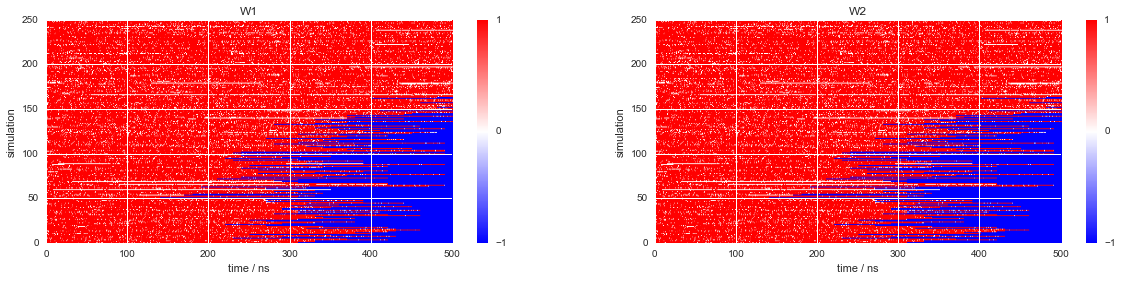

In [60]:
# Retrieve data
[W1, W2] = retrieve_data('-Tpx2 WT')

fig = plt.figure(figsize=[20, 4.])

plt.subplot(1,2,1);
X1 = water_occupation_array(W1)
plt.title('W1');
cax = plt.imshow(X, extent=[0, nframe/4., 0, ntraj], aspect='auto', cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
plt.xlabel('time / ns');
plt.ylabel('simulation');

plt.subplot(1,2,2);
X2 = water_occupation_array(W2)
plt.title('W2');
cax = plt.imshow(X, extent=[0, nframe/4., 0, ntraj], aspect='auto', cmap=plt.get_cmap('bwr'))
cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
plt.xlabel('time / ns');
plt.ylabel('simulation');

In [54]:
np.prod(X1.shape)

500000

In [61]:
W1[0,:]

array([set([4614]), set([4614]), set([]), ..., set([40818, 10749]),
       set([27489, 40818, 10749]), set([27489, 48123, 44526])], dtype=object)

In [ ]:
# Compute correlation function contributions
W = W1
[ntrajs, nframes] = W.shape
tmax = 250
C = np.zeros([ntrajs,tmax+1], np.float64)
for traj in range(ntrajs):   
    Wtraj = W[traj,:]
    nframes = np.sum(np.not_equal(Wtraj, None))
    for t in range(tmax+1):
        for t0 in range(nframes-t):
            same_waters = (len(Wtraj[t0].intersection(Wtraj[t0+t]))>0)
            C[traj,t] += same_waters / np.float(nframes-t)

In [ ]:
fig = plt.figure(figsize=[20, 4.])

plt.subplot(1,2,1);
plt.title('C(t) for W1');
cax = plt.imshow(C, extent=[0, tmax/4., 0, ntraj], aspect='auto', cmap=plt.get_cmap('bwr'))
#cbar = fig.colorbar(cax, ticks=[-1, 0, 1])
plt.xlabel('time / ns');
plt.ylabel('simulation');


In [ ]:
D = C.mean(0)
tvec = np.arange(D.shape[0]) / 4.
plt.plot(tvec, D)
plt.axis([0, tvec[-1], 0, 1]);
plt.xlabel('time / ns');
plt.ylabel('C(t)');